In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


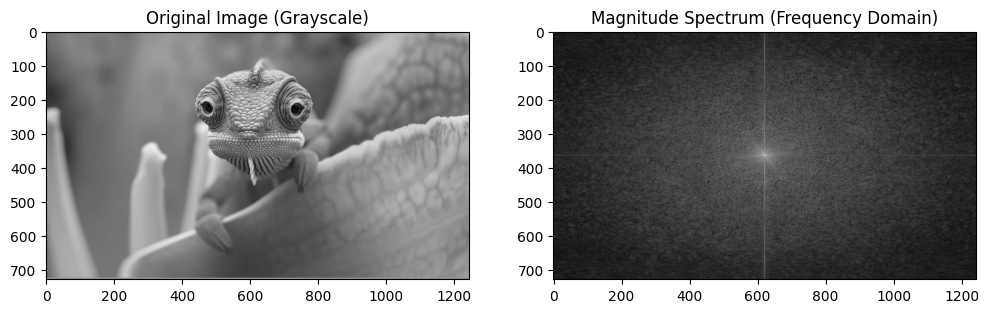

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from skimage import io, color

# Load the image
image = io.imread('/content/drive/MyDrive/MDS_project/Image_compressions/original_image.png')

# Check if the image has an alpha channel
if image.shape[2] == 4:
    image = image[:, :, :3]  # Remove the alpha channel

# Convert to grayscale
image_gray = color.rgb2gray(image)

# Apply FFT and shift zero-frequency component to the center
f_transform = fft2(image_gray)
f_transform_shifted = fftshift(f_transform)
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title("Original Image (Grayscale)")

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Magnitude Spectrum (Frequency Domain)")
plt.show()


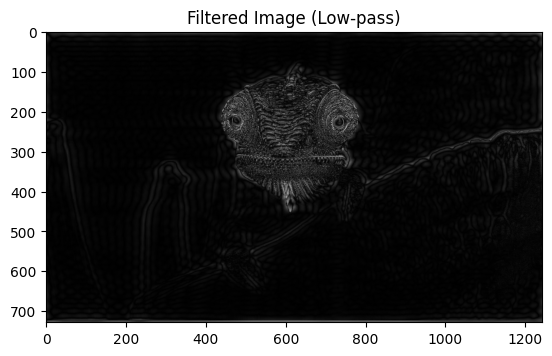

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `f_transform_shifted` is your frequency-domain data after applying `fftshift`
# Example setup for a low-pass filter
rows, cols = f_transform_shifted.shape
crow, ccol = rows // 2, cols // 2
f_transform_shifted[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0  # Removing high-frequency components

# Inverse FFT
filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(f_transform_shifted)))

# Plot filtered image
plt.imshow(filtered_image, cmap='gray')
plt.title("Filtered Image (Low-pass)")
plt.show()


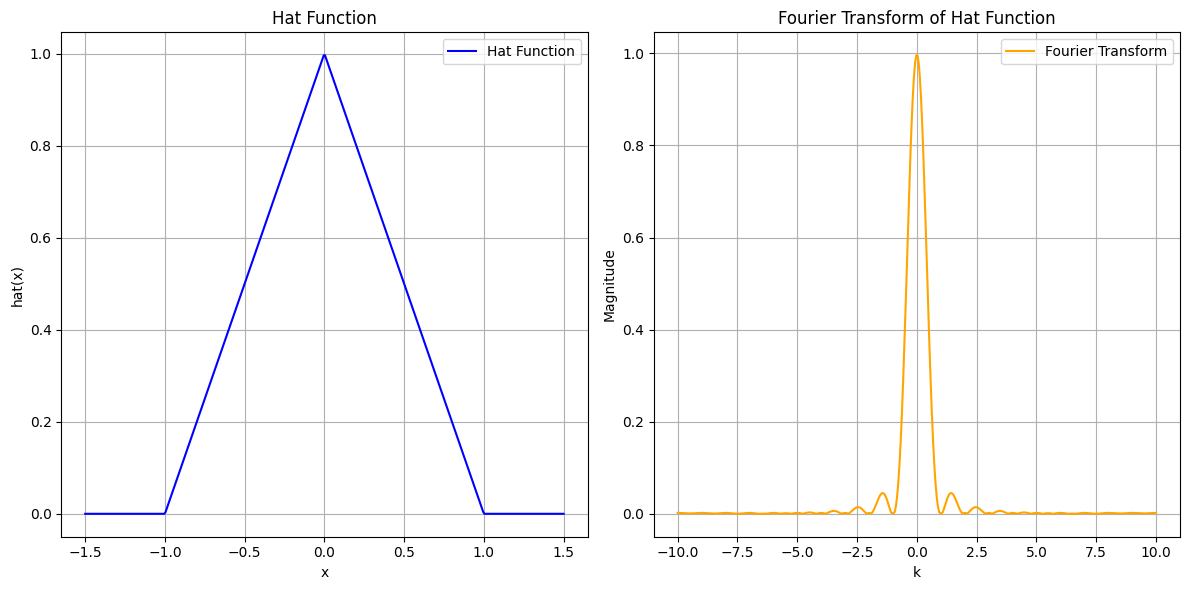

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the hat function
def hat_function(x):
    return np.maximum(0, 1 - np.abs(x))

# Fourier Transform
def fourier_transform(k, x):
    integral1 = np.trapz((1 + x[x < 0]) * np.exp(-2j * np.pi * k * x[x < 0]), x[x < 0])
    integral2 = np.trapz((1 - x[x > 0]) * np.exp(-2j * np.pi * k * x[x > 0]), x[x > 0])
    return integral1 + integral2

# Points for Fourier transform
k_values = np.linspace(-10, 10, 400)
x = np.linspace(-1, 1, 1000)  # Define x over which to compute the Fourier transform
fourier_values = [fourier_transform(k, x) for k in k_values]

# Plot the hat function and its Fourier transform
x_values = np.linspace(-1.5, 1.5, 400)
hat_values = hat_function(x_values)

plt.figure(figsize=(12, 6))

# Hat function
plt.subplot(1, 2, 1)
plt.plot(x_values, hat_values, label='Hat Function', color='blue')
plt.title('Hat Function')
plt.xlabel('x')
plt.ylabel('hat(x)')
plt.grid()
plt.legend()

# Fourier Transform
plt.subplot(1, 2, 2)
plt.plot(k_values, np.abs(fourier_values), label='Fourier Transform', color='orange')
plt.title('Fourier Transform of Hat Function')
plt.xlabel('k')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


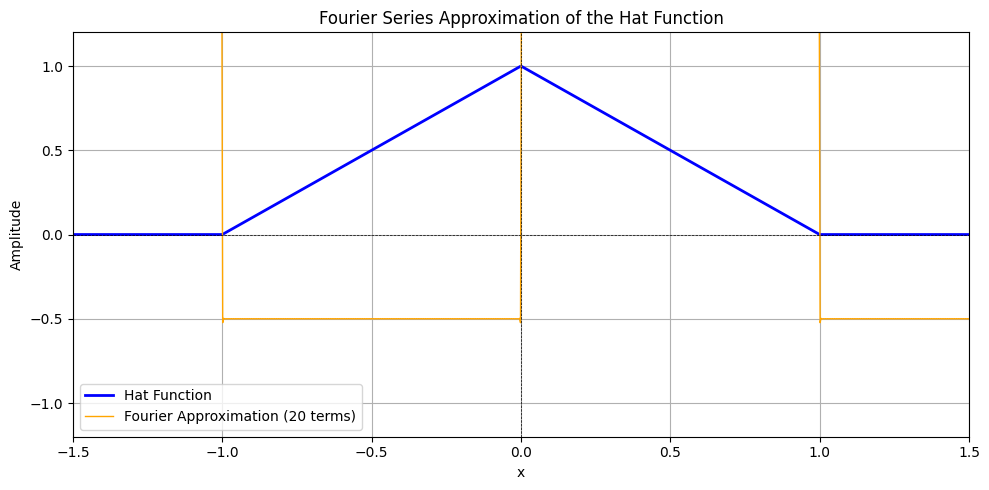

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the hat function
def hat_function(x):
    return np.maximum(0, 1 - np.abs(x))

# Compute Fourier coefficients
def compute_fourier_coefficients(n_terms):
    a_0 = 0.5  # Average value over the period (-1 to 1)
    a_n = np.zeros(n_terms)
    b_n = np.zeros(n_terms)

    for n in range(1, n_terms + 1):
        # Calculate a_n
        a_n[n - 1] = (1 / 2) * (np.sin(n * np.pi) - np.sin(0)) / (n * np.pi)  # Integral for cosine term
        # Calculate b_n
        b_n[n - 1] = (2 / (n * np.pi)) * (1 - (-1) ** n)  # Integral for sine term

    return a_0, a_n, b_n

# Number of terms to approximate
n_terms = 1000
a_0, a_n, b_n = compute_fourier_coefficients(n_terms)

# Create a range of x values
x = np.linspace(-1.5, 1.5, 1000)

# Compute the approximation of the hat function using the Fourier series
approximation = a_0 * np.ones_like(x)

for n in range(1, n_terms + 1):
    approximation += a_n[n - 1] * np.cos(n * np.pi * x) + b_n[n - 1] * np.sin(n * np.pi * x)

# Plot the hat function and its Fourier approximation
plt.figure(figsize=(10, 5))
plt.plot(x, hat_function(x), label='Hat Function', color='blue', linewidth=2)
plt.plot(x, approximation, label='Fourier Approximation (20 terms)', color='orange', linewidth=1)
plt.title('Fourier Series Approximation of the Hat Function')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.grid()
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.legend()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.2, 1.2)
plt.tight_layout()
plt.show()


**Image Compression**

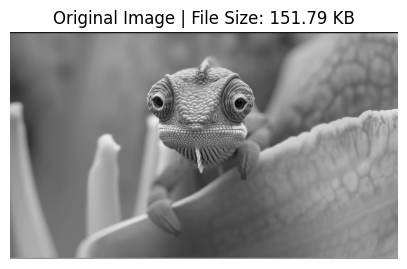

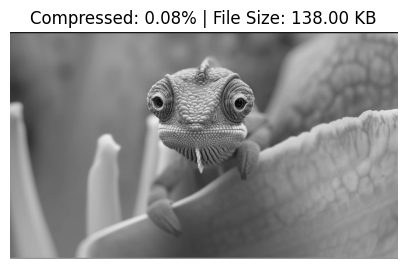

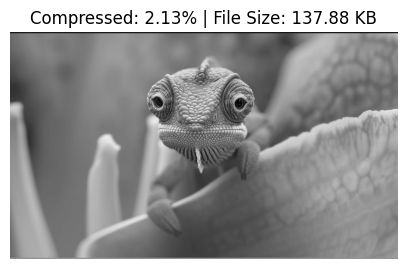

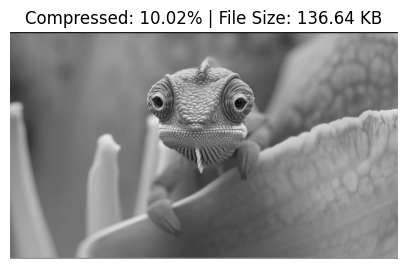

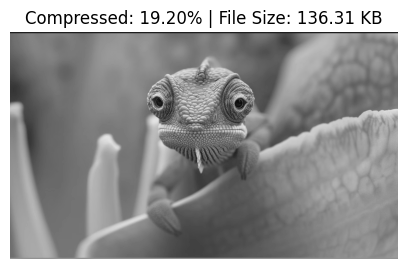

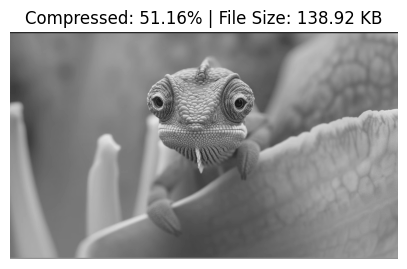

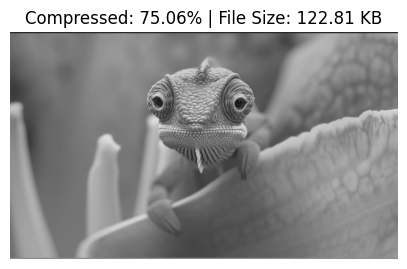

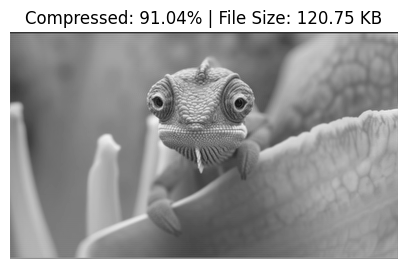

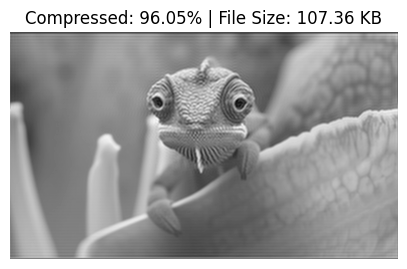

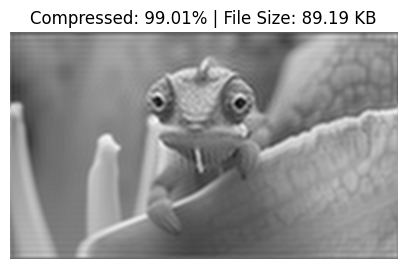

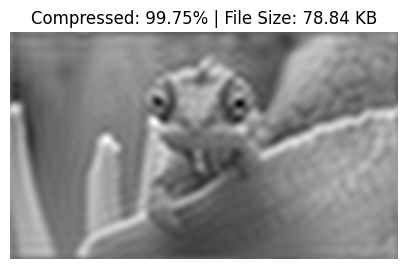

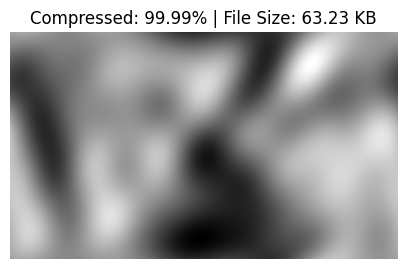

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_ubyte
from PIL import Image
import os

# Function to compress the image using FFT
def fft_compression(image, keep_fraction=0.1):
    # Perform the 2D FFT
    F = np.fft.fft2(image)
    Fshifted = np.fft.fftshift(F)

    # Zero out small coefficients (high frequencies)
    rows, cols = Fshifted.shape
    crow, ccol = rows // 2, cols // 2  # center

    # Create a mask with only the central keep_fraction frequencies
    mask = np.zeros_like(Fshifted)
    r_keep = int(rows * keep_fraction / 2)
    c_keep = int(cols * keep_fraction / 2)
    mask[crow-r_keep:crow+r_keep, ccol-c_keep:ccol+c_keep] = 1

    # Apply mask to keep only low frequencies
    Fshifted_compressed = Fshifted * mask

    # Inverse FFT to reconstruct the compressed image
    F_compressed = np.fft.ifftshift(Fshifted_compressed)
    compressed_image = np.fft.ifft2(F_compressed).real

    # Calculate compression ratio
    non_zero_original = np.count_nonzero(Fshifted)
    non_zero_compressed = np.count_nonzero(Fshifted_compressed)
    compression_ratio = (1 - non_zero_compressed / non_zero_original) * 100

    return compressed_image, compression_ratio

# Load and preprocess the image
image = io.imread('/content/drive/MyDrive/MDS_project/Image_compressions/original_image_rgb.png')
if image.shape[2] == 4:  # Remove alpha channel if it exists
    image = image[:, :, :3]
image = color.rgb2gray(image)  # Convert to grayscale

# Save the original image to calculate its size
original_image_path = "/content/drive/MyDrive/MDS_project/Image_compressions/original_image"
Image.fromarray(img_as_ubyte(image)).save(original_image_path, "JPEG", quality=96)
original_image_size_kb = os.path.getsize(original_image_path) / 1024  # Convert to KB

# Display the original image with size
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.title(f"Original Image | File Size: {original_image_size_kb:.2f} KB")
plt.axis('off')
plt.show()

# Create a folder to save compressed images
output_dir = "/content/drive/MyDrive/MDS_project/Image_compressions"
os.makedirs(output_dir, exist_ok=True)

# Compress the image with different keep_fraction values
keep_fractions = [1, 0.99, 0.95, 0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
compressed_images = []
compression_ratios = []

# Compress, save, and display each image with file size
for keep_fraction in keep_fractions:
    compressed_img, ratio = fft_compression(image, keep_fraction)
    compressed_images.append(compressed_img)
    compression_ratios.append(ratio)

    # Normalize to [0, 1] range and then convert to 8-bit for saving
    compressed_img_norm = (compressed_img - compressed_img.min()) / (compressed_img.max() - compressed_img.min())
    comp_img_8bit = img_as_ubyte(compressed_img_norm)

    # Save the compressed image as a JPEG
    filename = os.path.join(output_dir, f"compressed_{int(keep_fraction * 100)}%.jpg")
    Image.fromarray(comp_img_8bit).save(filename, "JPEG", quality=95)

    # Get file size in KB
    file_size_kb = os.path.getsize(filename) / 1024  # Convert to KB

    # Display each compressed image with compression details
    plt.figure(figsize=(5, 5))
    plt.imshow(compressed_img, cmap='gray')
    plt.title(f"Compressed: {ratio:.2f}% | File Size: {file_size_kb:.2f} KB")
    plt.axis('off')
    plt.show()


**Audio Compression**

In [ ]:
import soundfile as sf

# Save the original audio as an OGG file
original_audio_file = '/content/drive/MyDrive/MDS_project/Audio_compressions/original_audio.ogg'
sf.write(original_audio_file, audio_data, sample_rate)

# Get the size of the saved OGG file
original_ogg_size = os.path.getsize(original_audio_file)
print(f"Original OGG file size: {original_ogg_size / 1024:.2f} KB")


Original OGG file size: 79.23 KB


<ipython-input-31-ad01014d0497>:35: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read('/content/drive/MyDrive/MDS_project/Audio_compressions/original_audio.wav')


Original size of audio file is 1023.80 KB
Keep 50.0%: Compressed audio saved as '/content/drive/MyDrive/MDS_project/Audio_compressions/Compressed_audio_files/compressed_audio_50.ogg' with compression ratio: 50.00% and effective size: 79.23 KB
Keep 30.0%: Compressed audio saved as '/content/drive/MyDrive/MDS_project/Audio_compressions/Compressed_audio_files/compressed_audio_30.ogg' with compression ratio: 30.00% and effective size: 65.13 KB
Keep 20.0%: Compressed audio saved as '/content/drive/MyDrive/MDS_project/Audio_compressions/Compressed_audio_files/compressed_audio_20.ogg' with compression ratio: 20.00% and effective size: 54.75 KB
Keep 10.0%: Compressed audio saved as '/content/drive/MyDrive/MDS_project/Audio_compressions/Compressed_audio_files/compressed_audio_10.ogg' with compression ratio: 10.00% and effective size: 45.68 KB


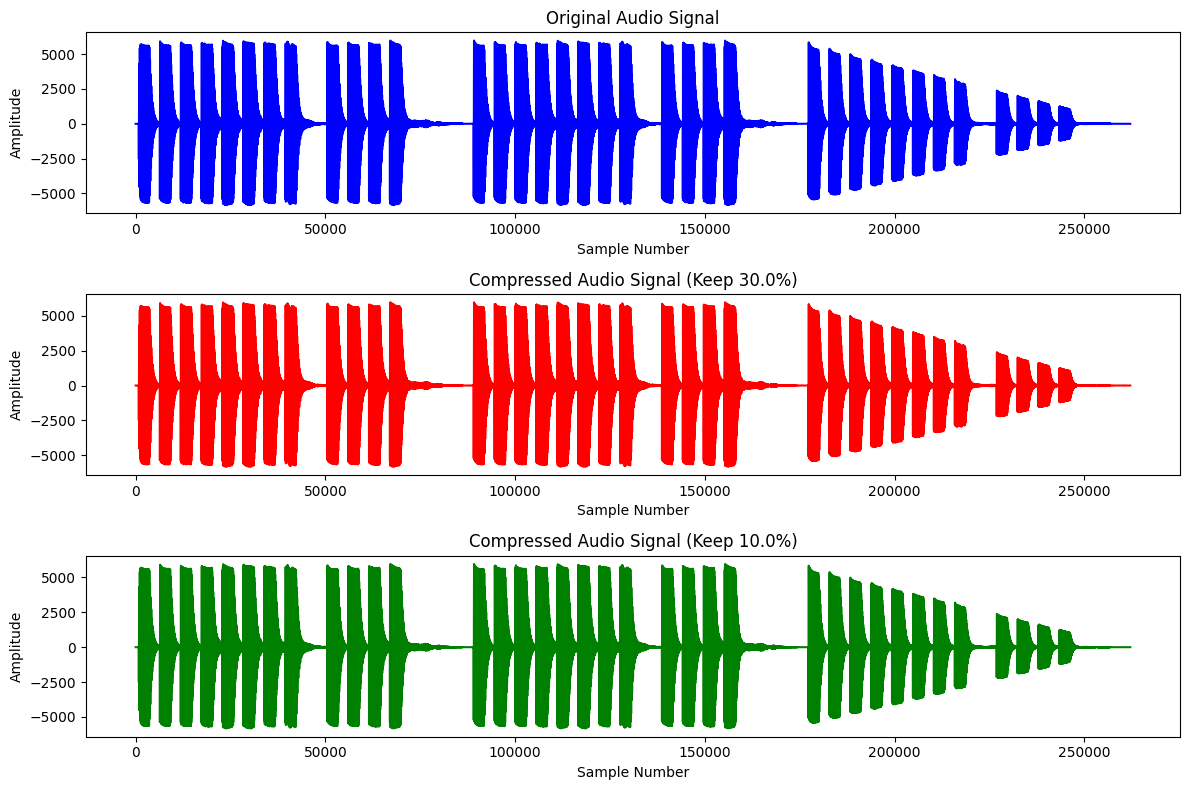

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import os

def fft_audio_compression(audio_data, sample_rate, keep_fraction=0.1):
    # Perform the FFT
    F = np.fft.fft(audio_data)

    # Zero out small coefficients (high frequencies)
    n = len(F)
    r_keep = int(n * keep_fraction)  # Number of coefficients to keep

    # Create a mask to keep only the low and high frequency components specified
    mask = np.zeros(n)
    mask[:r_keep] = 1  # Keep low frequencies
    mask[-r_keep:] = 1  # Keep corresponding negative frequencies

    # Apply the mask to the FFT coefficients
    F_compressed = F * mask

    # Inverse FFT to reconstruct the compressed audio
    compressed_audio = np.fft.ifft(F_compressed).real

    # Calculate the effective compressed size by counting the number of kept coefficients
    # The compressed size depends on the number of kept FFT coefficients
    compressed_size = F_compressed.nbytes
    original_size=audio_data.nbytes # Size of compressed FFT coefficients
    compression_ratio = keep_fraction*100  # Compression ratio based on FFT size

    return compressed_audio, compression_ratio, compressed_size

# Load the audio file
sample_rate, audio_data = wavfile.read('/content/drive/MyDrive/MDS_project/Audio_compressions/original_audio.wav')
original_size = audio_data.nbytes
print(f"Original size of audio file is {original_size / 1024:.2f} KB")

# Convert stereo to mono if necessary
if audio_data.ndim > 1:
    audio_data = audio_data.mean(axis=1)  # Average the two channels

# Compress the audio with different keep_fraction values
keep_fractions = [ 0.5, 0.3, 0.2, 0.1]
compressed_audios = []
compression_ratios = []
compressed_sizes = []

# Directory to save the compressed files in Google Drive
output_dir = '/content/drive/MyDrive/MDS_project/Audio_compressions/Compressed_audio_files'
os.makedirs(output_dir, exist_ok=True)

for keep_fraction in keep_fractions:
    compressed_audio, ratio, size = fft_audio_compression(audio_data, sample_rate, keep_fraction)
    compressed_audios.append(compressed_audio)
    compression_ratios.append(ratio)
    compressed_sizes.append(size)

# Save compressed audio files and display compression ratios and sizes
for i, (comp_audio, ratio, size) in enumerate(zip(compressed_audios, compression_ratios, compressed_sizes)):
    file_path = os.path.join(output_dir, f'compressed_audio_{int(keep_fractions[i] * 100)}.ogg')
    # Save as OGG file
    sf.write(file_path, comp_audio, sample_rate)
    # Check if the file is smaller after compression (manually checking the file size)
    file_size = os.path.getsize(file_path)
    print(f"Keep {keep_fractions[i] * 100}%: Compressed audio saved as '{file_path}' with compression ratio: {ratio:.2f}% and effective size: {file_size / 1024:.2f} KB")

# Plot the original and compressed audio waveforms for the first and last keep_fraction
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(audio_data, color='blue')
plt.title('Original Audio Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(compressed_audios[1], color='red')  # Plot first compressed audio
plt.title(f'Compressed Audio Signal (Keep {keep_fractions[1] * 100}%)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(compressed_audios[-1], color='green')  # Plot last compressed audio
plt.title(f'Compressed Audio Signal (Keep {keep_fractions[-1] * 100}%)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


**Audio Filteration**

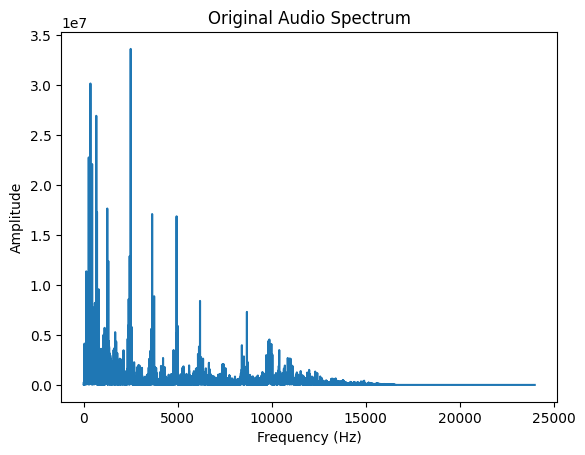

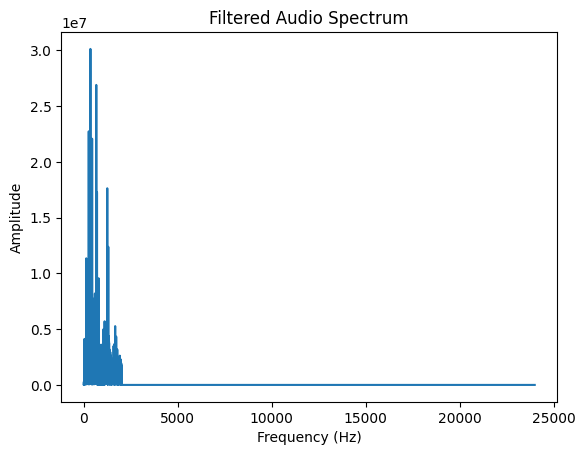

In [2]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.fftpack as fft
import matplotlib.pyplot as plt

# Load the audio file
sample_rate, audio_data = wav.read('/content/drive/MyDrive/MDS_project/Audio_filteration/input_audio.wav')

# Ensure it's a mono channel audio (1D array)
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# Perform FFT to convert audio to frequency domain
audio_fft = fft.fft(audio_data)

# Get the corresponding frequencies
frequencies = np.fft.fftfreq(len(audio_data), 1/sample_rate)

# Define a cutoff frequency above which the noise is considered (e.g., 5000 Hz for high-pitched noise)
cutoff_frequency = 2000

# Create a mask that zeros out frequencies above the cutoff
audio_fft_filtered = np.copy(audio_fft)
audio_fft_filtered[np.abs(frequencies) > cutoff_frequency] = 0

# Perform IFFT to convert the audio back to the time domain
filtered_audio_data = np.real(fft.ifft(audio_fft_filtered))

# Normalize the audio to the range of 16-bit signed integers
filtered_audio_data = np.int16(filtered_audio_data / np.max(np.abs(filtered_audio_data)) * 32767)

# Save the filtered audio to a new file
wav.write('/content/drive/MyDrive/MDS_project/Audio_filteration/filtered_audio.wav', sample_rate, filtered_audio_data)

# Plot the frequency spectrum before and after filtering
# plt.figure(figsize=(12, 6))

# Original audio spectrum
# plt.subplot(1, 2, 1)
plt.title('Original Audio Spectrum')
plt.plot(frequencies[:len(frequencies)//2], np.abs(audio_fft)[:len(frequencies)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# Filtered audio spectrum
# plt.subplot(1, 2, 2)
plt.title('Filtered Audio Spectrum')
plt.plot(frequencies[:len(frequencies)//2], np.abs(audio_fft_filtered)[:len(frequencies)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# plt.tight_layout()
plt.show()
